## XRAY - VGG16

In [1]:
#Importing Necessary Libraries.
from PIL import Image
import numpy as np
import pandas as pd 
import os
#import cv2

import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)
    
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras_lr_finder import LRFinder
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras import backend
from tensorflow.python.keras.applications import imagenet_utils
from tensorflow.python.keras.applications.vgg16 import preprocess_input


from sklearn.utils import class_weight 

print(tf.__version__)
tf.config.list_physical_devices('GPU')

1 Physical GPUs, 1 Logical GPUs
2.2.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
database_directory = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY/"
res_list = [224]
out_dir = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/1TRAIN/VGG_NET/X-RAY/OUT/"
max_epochs = 15

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_and_save(history, modelName, path):
    fig, axs = plt.subplots(2, figsize=(18, 10))
    axs[0].set_ylim(0,1)
    axs[0].plot(range(1,max_epochs+1), history['accuracy'], 'o-')
    axs[0].plot(range(1,max_epochs+1), history['val_accuracy'], 'o-')
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'], loc='lower left')
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_xticks(range(1,max_epochs+1))

    # "Loss"
    axs[1].plot(range(1,max_epochs+1), history['loss'], 'o-')
    axs[1].plot(range(1,max_epochs+1),history['val_loss'], 'o-')
    axs[1].set_title('model loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'], loc='upper left')
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].set_xticks(range(1,max_epochs+1))
    
    plt.savefig(path+  modelName +'.png')
    plt.show()
    plt.draw()
#plot_and_save(history, modelName)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

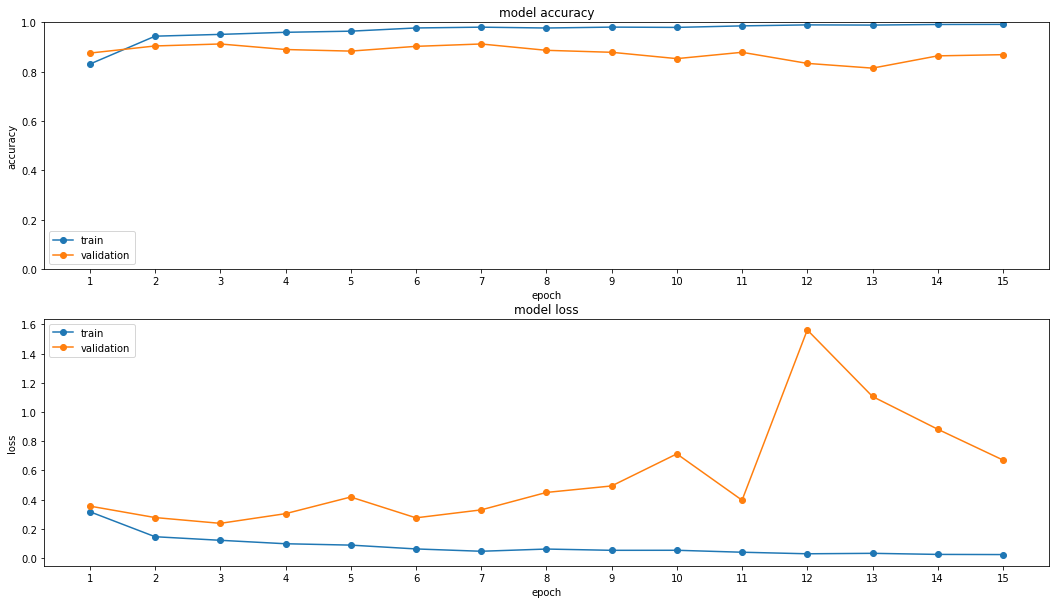

<Figure size 432x288 with 0 Axes>

In [4]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=10e-5, decay_factor=0.75, step_size=5)

def train(res, train_generator, test_generator, class_weights):
    modelName = 'VGG_res_10e5_75_weight'+str(res)
    Path.mkdir(Path(out_dir+modelName), parents=True, exist_ok=True)
    out_run = out_dir+modelName+"/"
    model = tf.keras.applications.VGG16(input_shape=(res, res, 3), include_top=True,weights = None, classes=2)
    model.summary()
    mc = keras.callbacks.ModelCheckpoint(out_run + modelName+'_w{epoch:05d}.h5', save_weights_only=False, period=1)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(x=train_generator,epochs=max_epochs,validation_data=test_generator, callbacks=[mc, lr_sched], shuffle=True, class_weight=class_weights)
    np.save(out_run + modelName +'my_history.npy',history.history)
    plot_model(model, to_file= out_run + modelName+'_arc.png',expand_nested=True, show_shapes=True)
    plot_and_save(history.history, modelName, out_run)

for res in res_list:
    h_input = res
    w_input = res
    batch_size = 16
    

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_generator = train_datagen.flow_from_directory(
            database_directory+"train",
            batch_size=batch_size,
            target_size=(res, res),
            class_mode='categorical')

    # this is a similar generator, for validation data
    test_generator = test_datagen.flow_from_directory(
            database_directory+"test",
            batch_size=batch_size,
            target_size=(res, res),
            class_mode='categorical')
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
    class_weights = dict(enumerate(class_weights))

    
    train(res, train_generator, test_generator, class_weights)

## Blocks

In [ ]:
layers = VersionAwareLayers()

def teste(
    include_top=True,
    input_tensor=None,
    input_shape=None,
    classes=1000,
    classifier_activation='softmax',
    blocks = 5):

    input_shape = imagenet_utils.obtain_input_shape(
      input_shape,
      default_size=224,
      min_size=32,
      data_format=backend.image_data_format(),
      require_flatten=include_top,
      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if(blocks >= 1):
        # Block 1
        x = layers.Conv2D(
        64, (3, 3), activation='relu', padding='same', name='block1_conv1')(
        img_input)
        x = layers.Conv2D(
        64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    if(blocks >= 2):
        # Block 2
        x = layers.Conv2D(
        128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
        x = layers.Conv2D(
        128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    if(blocks >= 3):
        # Block 3
        x = layers.Conv2D(
        256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
        x = layers.Conv2D(
        256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
        x = layers.Conv2D(
        256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    if(blocks >= 4):
        # Block 4
        x = layers.Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
        x = layers.Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
        x = layers.Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    if(blocks >= 5):
        # Block 5
        x = layers.Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
        x = layers.Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
        x = layers.Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
        
    if include_top:
        # Classification block
        #x = layers.Flatten(name='flatten')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        x = layers.Dense(4096, activation='relu', name='fc2')(x)

        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(classes, activation=classifier_activation,
                         name='predictions')(x)

    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    model = training.Model(inputs, x, name='vgg16')

    return model

In [ ]:
model = teste(input_shape=(255, 255, 3), include_top=True,weights = None, classes=2, blocks = 4)

# TESTE

In [ ]:
res = 224
h_input = 224
w_input = 224
batch_size = 16


train_datagen = ImageDataGenerator(horizontal_flip=True)
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
        database_directory+"train",
        target_size=(h_input, w_input),
        batch_size=batch_size,
        class_mode='categorical')

# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        database_directory+"test",
        target_size=(h_input, w_input),
        batch_size=batch_size,
        class_mode='categorical')

modelName = 'VGG_res_'+str(res)
model = tf.keras.applications.VGG16(input_shape=(res, res, 3), include_top=True,weights = None, classes=2)
model.summary()

optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#history = model.fit(x=train_generator,epochs=max_epochs,validation_data=test_generator,  shuffle=True)

In [5]:
# model is a Keras model
lr_finder = LRFinder(model)

In [ ]:
lr_finder.find(x_train, y_train, 0.0001, 1, 32, 5)

In [ ]:
len() 

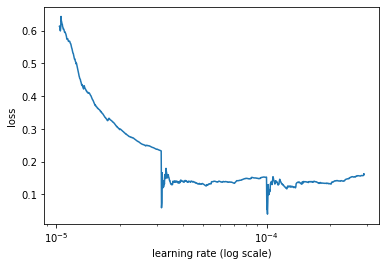

In [21]:
lr_finder.plot_loss()

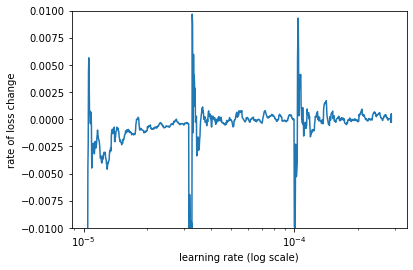

In [27]:
lr_finder.plot_loss_change(sma=10)

In [29]:
lr_finder.get_best_lr(sma=5)

IndexError: invalid index to scalar variable.

In [4]:
from matplotlib import pyplot as plt
import math
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K
import numpy as np


class LRFinder2:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]
